In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Chargement des données
df = pd.read_csv("airbnb_train.csv")

# ========== 1. Nettoyage des données ==========

# Supprimer colonnes trop manquantes
df = df.drop(columns=['host_response_rate'])

# Imputer les colonnes numériques
num_cols = ['bathrooms', 'bedrooms', 'beds']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Colonnes catégorielles/textuelles
df['neighbourhood'] = df['neighbourhood'].fillna('Unknown')
df['zipcode'] = df['zipcode'].fillna('00000')

# Booléen -> 0/1
df['cleaning_fee'] = df['cleaning_fee'].astype(bool).astype(int)

# Transformer `last_review` en nombre de jours depuis
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['days_since_last_review'] = (datetime.now() - df['last_review']).dt.days
df['days_since_last_review'] = df['days_since_last_review'].fillna(df['days_since_last_review'].median())

# Autres colonnes à faible taux de NaN
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())
df['host_identity_verified'] = df['host_identity_verified'].fillna('unverified')
df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna('f')
df['host_since'] = df['host_since'].fillna('unknown')
df['first_review'] = df['first_review'].fillna('unknown')

# ========== 2. Sélection des variables utiles ==========

# Colonnes à garder (possibilité d'enrichir)
features = [
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'bed_type', 'cancellation_policy', 'cleaning_fee', 'number_of_reviews',
    'review_scores_rating', 'days_since_last_review', 'neighbourhood'
]

X = df[features]
y = df['log_price']

# ========== 3. Pipeline de prétraitement ==========

# Colonnes numériques et catégorielles
numerical = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
             'number_of_reviews', 'review_scores_rating', 'days_since_last_review']
categorical = list(set(features) - set(numerical))

# Pipeline de transformation
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

# Pipeline complet avec un modèle simple
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# ========== 4. Split des données & entraînement ==========

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ========== 5. Évaluation du modèle ==========

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE (log_price) : {rmse:.4f}")


RMSE (log_price) : 0.4341


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Chargement des données
airbnb = pd.read_csv("airbnb_train.csv")

# ========== TRANSFORMATION CUSTOM ==========

class CustomTransformation():
    def __init__(self):
        self.fitted = False
        self.property2index = dict()
        self.max_index = 0

    def fit_transform(self, dataset):
        self.fitted = True
        properties = dataset["property_type"].unique()
        self.property2index = {prop: i for i, prop in enumerate(properties)}
        self.max_index = max(self.property2index.values())
        return self.transform(dataset)
    
    def transform(self, dataset):
        dataset = dataset.copy()

        # Encode property_type
        dataset["property_type"] = dataset["property_type"].replace(self.property2index)

        # Gestion des types inconnus dans le test
        dataset.loc[dataset["property_type"].map(type) == str, "property_type"] = self.max_index + 1

        # Gestion des valeurs manquantes spécifiques
        dataset["bathrooms"] = dataset["bathrooms"].fillna(0)
        dataset["accommodates"] = dataset["accommodates"].fillna(0)
        dataset["property_type"] = dataset["property_type"].fillna(self.max_index + 1)
        
        return dataset

# ========== FEATURE SELECTION ==========

class FeatureSelection():
    def __init__(self):
        self.cols = ["property_type", "accommodates", "bathrooms"]

    def fit_transform(self, dataset, y=None):
        return self.transform(dataset)

    def transform(self, dataset):
        dataset = dataset[self.cols].copy()
        for col in dataset.columns:
            dataset[col] = pd.to_numeric(dataset[col])
        return dataset

# Initialiser les classes
features_transformer = CustomTransformation()
feature_selector = FeatureSelection()

# Pipeline d'entraînement
airbnb_train = features_transformer.fit_transform(airbnb)
airbnb_train = feature_selector.transform(airbnb_train)

# Variables
X = airbnb_train
y = airbnb["log_price"]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2)

# Modèle
model = LinearSVR()
model.fit(X_train, y_train)

# Prédictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Évaluation
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Score entraînement (R²): {r2_train:.4f}")
print(f"Score test (R²): {r2_test:.4f}")
print(f"RMSE test : {rmse_test:.4f}")

# ========== PRÉDICTION FINALE SUR airbnb_test.csv ==========

airbnb_test = pd.read_csv("airbnb_test.csv")

# Application du pipeline
final_X_test = features_transformer.transform(airbnb_test)
final_X_test = feature_selector.transform(final_X_test)
final_X_test_scaled = scaler.transform(final_X_test)

# Prédictions finales
y_final_prediction = model.predict(final_X_test_scaled)

# Affichage
print("\nPrédictions sur le fichier airbnb_test.csv :")
print(y_final_prediction)

prediction_example = pd.read_csv("prediction_example.csv")
prediction_example["logpred"] = y_final_prediction

prediction_example.to_csv("MaPredictionFinale.csv", index=False) # index=False pour éviter d’ajouter l’index interne à pandas
# Voilà !

def estConforme(monFichier_csv):
    votre_prediction = pd.read_csv(monFichier_csv)

    fichier_exemple = pd.read_csv("prediction_example.csv")

    assert votre_prediction.columns[1] == fichier_exemple.columns[1], f"Attention, votre colonne de prédiction doit s'appeler {fichier_exemple.columns[1]}, elle s'appelle '{votre_prediction.columns[1]}'"
    assert len(votre_prediction) == len(fichier_exemple), f"Attention, vous devriez avoir {len(fichier_exemple)} prédiction dans votre fichier, il en contient '{len(votre_prediction)}'"

    assert np.all(votre_prediction.iloc[:,0] == fichier_exemple.iloc[:, 0])

    print("Fichier conforme!")

estConforme("MaPredictionFinale.csv")

C:\Users\Aurélien\AppData\Local\Temp\ipykernel_2624\1252774213.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["property_type"] = dataset["property_type"].replace(self.property2index)


Score entraînement (R²): 0.3245
Score test (R²): 0.3189
RMSE test : 0.5907

Prédictions sur le fichier airbnb_test.csv :
[4.70275327 5.47032831 5.08654079 ... 4.70275327 4.8868808  4.70275327]
Fichier conforme!


C:\Users\Aurélien\AppData\Local\Temp\ipykernel_2624\1252774213.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["property_type"] = dataset["property_type"].fillna(self.max_index + 1)


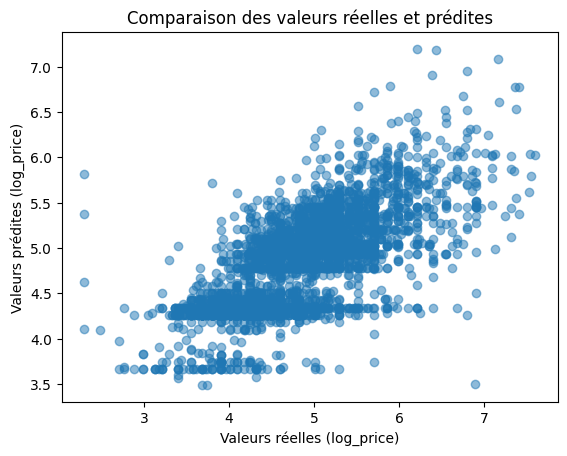

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeurs réelles (log_price)")
plt.ylabel("Valeurs prédites (log_price)")
plt.title("Comparaison des valeurs réelles et prédites")
plt.show()

In [4]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.4341


In [5]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

R²: 0.6322


Colonnes numériques disponibles :
['id', 'log_price', 'accommodates', 'bathrooms', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']

Colonnes les plus corrélées à log_price :
log_price               1.000000
accommodates            0.564874
bedrooms                0.472871
beds                    0.435212
bathrooms               0.369118
review_scores_rating    0.092342
latitude                0.005231
id                     -0.002122
number_of_reviews      -0.039138
longitude              -0.045348
Name: log_price, dtype: float64


C:\Users\Aurélien\AppData\Local\Temp\ipykernel_2624\1182851836.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")


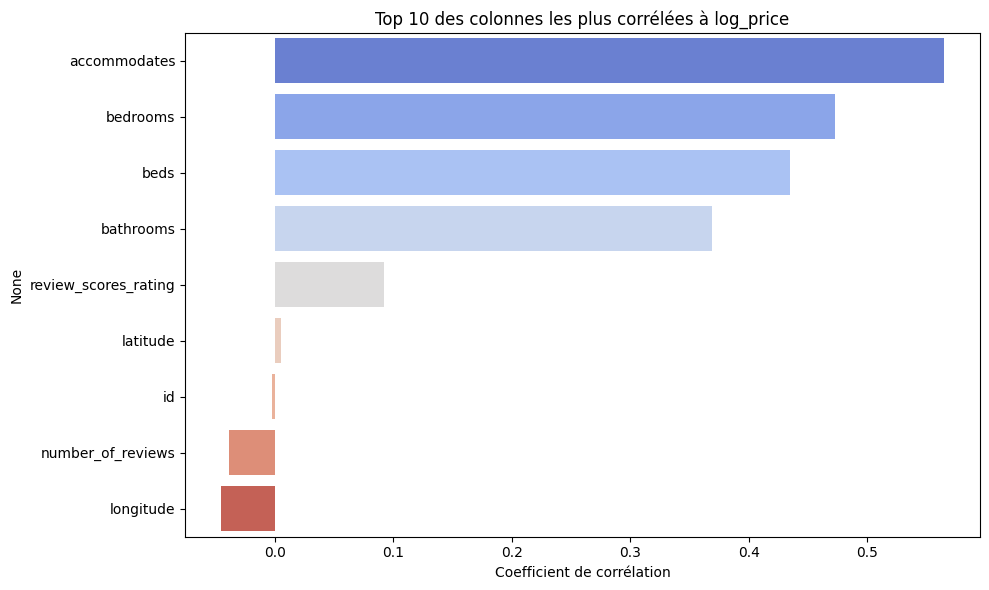

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv("airbnb_train.csv")

# On convertit les colonnes non numériques ignorées pour la corrélation
df_numeric = df.select_dtypes(include=[np.number])

# Affiche les colonnes disponibles
print("Colonnes numériques disponibles :")
print(df_numeric.columns.tolist())

# Calcul des corrélations avec log_price
correlation_matrix = df_numeric.corr()

# Tri des colonnes les plus corrélées à log_price
target_corr = correlation_matrix["log_price"].sort_values(ascending=False)

print("\nColonnes les plus corrélées à log_price :")
print(target_corr)

# Affichage graphique des 10 meilleures corrélations (hors log_price elle-même)
plt.figure(figsize=(10, 6))
top_corr = target_corr.drop("log_price").head(10)
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Top 10 des colonnes les plus corrélées à log_price")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()



Colonnes les plus corrélées (y compris les catégorielles encodées) :
log_price                 1.000000
accommodates              0.564874
bedrooms                  0.472871
beds                      0.435212
bathrooms                 0.369118
amenities                 0.126556
cancellation_policy       0.125580
cleaning_fee              0.115116
bed_type                  0.097052
review_scores_rating      0.092342
property_type             0.042389
host_response_rate        0.042209
neighbourhood             0.038004
city                      0.035166
host_identity_verified    0.030548
last_review               0.027050
zipcode                   0.019074
latitude                  0.005231
id                       -0.002122
first_review             -0.006976
host_has_profile_pic     -0.010082
name                     -0.029197
description              -0.030950
number_of_reviews        -0.039138
instant_bookable         -0.040482
longitude                -0.045348
host_since          

C:\Users\Aurélien\AppData\Local\Temp\ipykernel_2624\2862101792.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="magma")


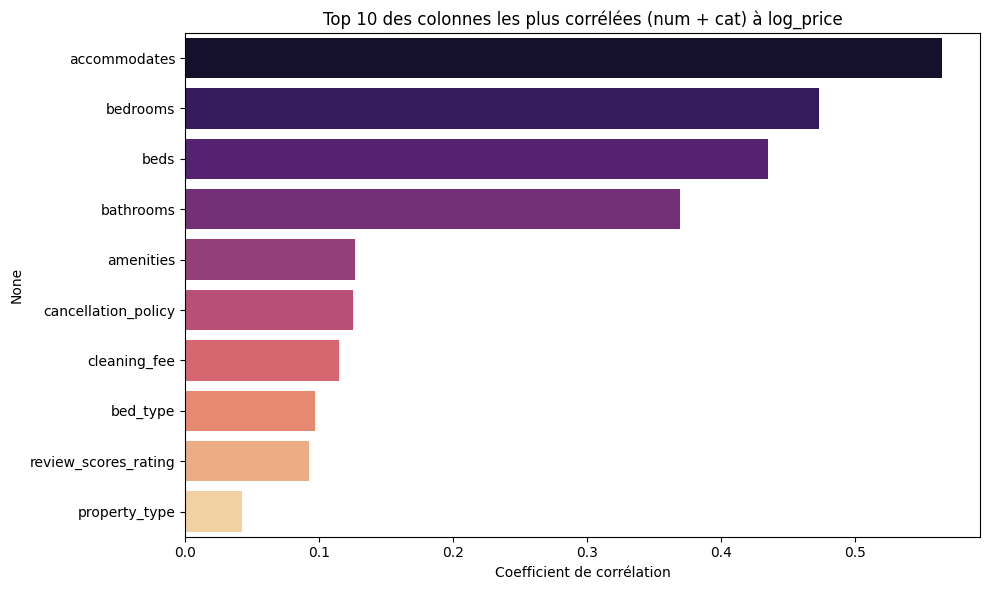

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv("airbnb_train.csv")

# Copie du dataframe
df_encoded = df.copy()

# Liste des colonnes non numériques
cat_cols = df.select_dtypes(include=["object"]).columns

# Encodage des colonnes catégorielles
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    try:
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    except Exception as e:
        print(f"Erreur sur la colonne {col} : {e}")

# Calcul de la corrélation
correlation_matrix = df_encoded.corr()

# Corrélation avec log_price uniquement
correlations_with_target = correlation_matrix["log_price"].sort_values(ascending=False)

# Affiche les corrélations (numériques + encodées)
print("\nColonnes les plus corrélées (y compris les catégorielles encodées) :")
print(correlations_with_target)

# Affiche un graphique pour les 10 meilleures
plt.figure(figsize=(10, 6))
top_corr = correlations_with_target.drop("log_price").head(10)
sns.barplot(x=top_corr.values, y=top_corr.index, palette="magma")
plt.title("Top 10 des colonnes les plus corrélées (num + cat) à log_price")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()


C:\Users\Aurélien\AppData\Local\Temp\ipykernel_2624\2322594057.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_combined.values, y=top_combined.index, palette="coolwarm")


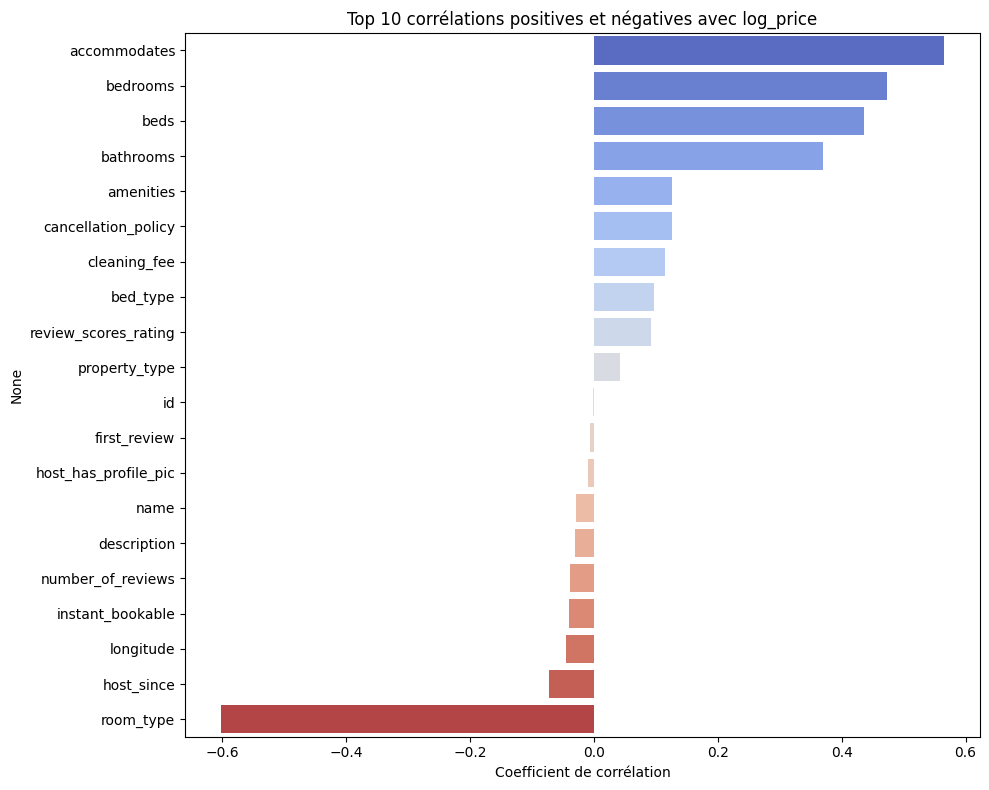

In [9]:
# Top 10 positives et négatives (hors log_price lui-même)
top_pos = correlations_with_target.drop("log_price").head(10)
top_neg = correlations_with_target.drop("log_price").tail(10)

# Concaténer pour visualisation
top_combined = pd.concat([top_pos, top_neg])

plt.figure(figsize=(10, 8))
sns.barplot(x=top_combined.values, y=top_combined.index, palette="coolwarm")
plt.title("Top 10 corrélations positives et négatives avec log_price")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()

In [10]:
# Seuil de corrélation absolue
correlation_threshold = 0.2

# Filtrer les colonnes pertinentes
strong_corr = correlations_with_target[correlations_with_target.abs() > correlation_threshold]
strong_corr = strong_corr.drop("log_price")  # on exclut la target

# Liste des features sélectionnées
selected_features = strong_corr.index.tolist()

print("\nFeatures sélectionnées pour la régression (|corr| > 0.2) :")
print(selected_features)




Features sélectionnées pour la régression (|corr| > 0.2) :
['accommodates', 'bedrooms', 'beds', 'bathrooms', 'room_type']


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Chargement des données
df = pd.read_csv("airbnb_train.csv")
df_encoded = df.copy()

# Encodage des colonnes catégorielles
cat_cols = df.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    try:
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    except Exception as e:
        print(f"Erreur sur la colonne {col} : {e}")

# Remplir les NaN par la médiane pour les colonnes numériques
df_encoded.fillna(df_encoded.median(numeric_only=True), inplace=True)

# Corrélation avec log_price
correlations = df_encoded.corr()["log_price"].drop("log_price")
selected_features = correlations[correlations.abs() > 0.2].index.tolist()

# Séparer X et y
X = df_encoded[selected_features]
y = df_encoded["log_price"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE : {rmse:.3f} | R² : {r2:.3f}")

# === Prédiction finale ===
# Charger le fichier d'exemple
prediction_example = pd.read_csv("prediction_example.csv")

# Adapter les features : ne garder que celles présentes
available_features = [col for col in selected_features if col in prediction_example.columns]

# Compléter les colonnes manquantes avec 0 (ou autre valeur par défaut)
for col in selected_features:
    if col not in prediction_example.columns:
        prediction_example[col] = 0  # ou mediane globale, si tu préfères

# Encodage des colonnes catégorielles (si besoin)
for col in selected_features:
    if col in label_encoders:
        le = label_encoders[col]
        try:
            prediction_example[col] = le.transform(prediction_example[col].astype(str))
        except:
            prediction_example[col] = 0  # fallback si valeur inconnue

# Remplissage des NaN
prediction_example[selected_features] = prediction_example[selected_features].fillna(
    df_encoded[selected_features].median(numeric_only=True)
)

# Prédiction
X_final = prediction_example[selected_features]
y_final_prediction = model.predict(X_final)

# Génération du fichier final
prediction_example["logpred"] = y_final_prediction
prediction_example.to_csv("MaPredictionFinale.csv", index=False)

# Vérification
estConforme("MaPredictionFinale.csv")


RMSE : 0.504 | R² : 0.504
Fichier conforme!


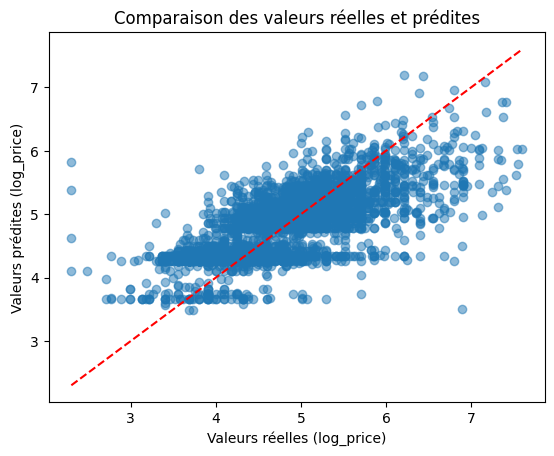

In [15]:
import matplotlib.pyplot as plt

# Scatter plot des valeurs réelles vs prédites
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeurs réelles (log_price)")
plt.ylabel("Valeurs prédites (log_price)")
plt.title("Comparaison des valeurs réelles et prédites")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Ligne idéale
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.5043


In [22]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

MAE: 0.3806


In [23]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

R²: 0.5036


In [24]:
comparison = pd.DataFrame({'Valeurs réelles': y_test, 'Valeurs prédites': y_pred})
print(comparison.head(10))

       Valeurs réelles  Valeurs prédites
14111         5.393628          4.964581
17805         3.912023          5.293835
18786         5.416100          5.139240
259           3.806662          4.262966
6062          5.700444          5.134982
14080         4.382027          4.262966
12747         3.218876          3.665098
9701          4.219508          4.342392
10884         4.553877          4.262966
2698          4.605170          4.342392


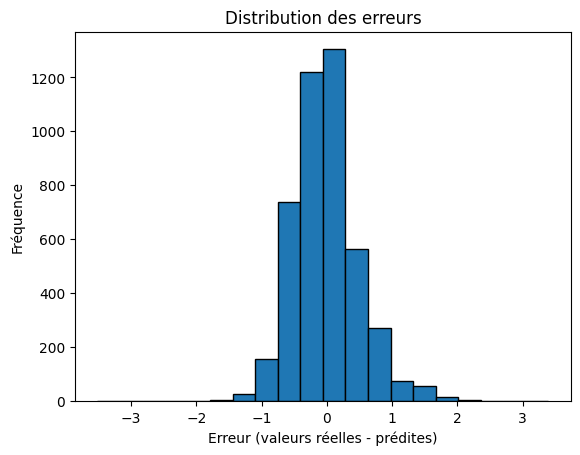

In [25]:
errors = y_test - y_pred
plt.hist(errors, bins=20, edgecolor='k')
plt.xlabel("Erreur (valeurs réelles - prédites)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs")
plt.show()

C:\Users\Aurélien\AppData\Local\Temp\ipykernel_2624\2967560836.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Valeurs réelles", shade=True)
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_2624\2967560836.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label="Valeurs prédites", shade=True)


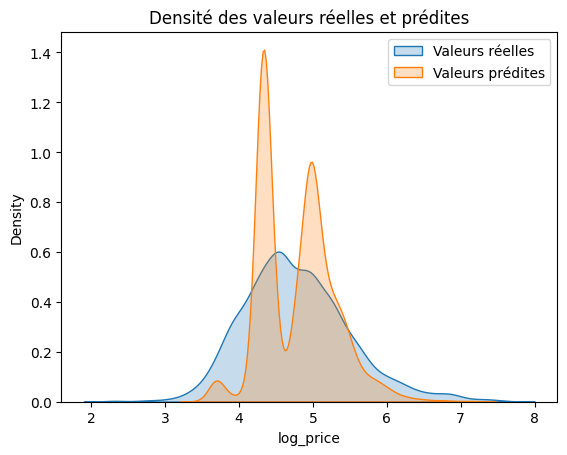

In [26]:
import seaborn as sns

sns.kdeplot(y_test, label="Valeurs réelles", shade=True)
sns.kdeplot(y_pred, label="Valeurs prédites", shade=True)
plt.legend()
plt.title("Densité des valeurs réelles et prédites")
plt.show()

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Charger les données
df = pd.read_csv("airbnb_train.csv")

# Colonnes utilisées pour la prédiction
features = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities',
    'cancellation_policy', 'cleaning_fee', 'bed_type',
    'review_scores_rating', 'property_type'
]

# Supprimer les lignes avec des valeurs manquantes dans la cible
df = df.dropna(subset=['log_price'])

# Séparer les features et la cible
X = df[features]
y = df['log_price']

# Identifier les colonnes numériques et catégoriques
numerical = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_rating']
categorical = ['amenities', 'cancellation_policy', 'cleaning_fee', 'bed_type', 'property_type']

# Pipeline de prétraitement
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

# Pipeline complet avec un modèle de régression linéaire
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Exemple de prédiction sur de nouvelles données
new_data = pd.DataFrame({
    'accommodates': [2],
    'bedrooms': [1],
    'beds': [1],
    'bathrooms': [1],
    'amenities': ['Wifi, Kitchen'],
    'cancellation_policy': ['flexible'],
    'cleaning_fee': [1],
    'bed_type': ['Real Bed'],
    'review_scores_rating': [95],
    'property_type': ['Apartment']
})

predicted_log_price = model.predict(new_data)
print(f"Prédiction du log_price: {predicted_log_price[0]:.4f}")

# Sauvegarder les prédictions dans un fichier CSV
prediction_example = pd.read_csv("prediction_example.csv")
prediction_example["logpred"] = y_final_prediction

# Sauvegarder dans un fichier nommé "MaPredictionFinale.csv"
prediction_example.to_csv("MaPredictionFinale.csv", index=False)  # index=False pour éviter d’ajouter l’index interne à pandas
print("Fichier de prédictions sauvegardé sous le nom 'MaPredictionFinale.csv'.")

# Fonction pour vérifier la conformité du fichier
def estConforme(monFichier_csv):
    votre_prediction = pd.read_csv(monFichier_csv)
    fichier_exemple = pd.read_csv("prediction_example.csv")

    # Vérifier que la colonne de prédiction a le bon nom
    assert votre_prediction.columns[1] == fichier_exemple.columns[1], f"Attention, votre colonne de prédiction doit s'appeler {fichier_exemple.columns[1]}, elle s'appelle '{votre_prediction.columns[1]}'"
    
    # Vérifier que le nombre de lignes est correct
    assert len(votre_prediction) == len(fichier_exemple), f"Attention, vous devriez avoir {len(fichier_exemple)} prédictions dans votre fichier, il en contient '{len(votre_prediction)}'"
    
    # Vérifier que les identifiants des lignes correspondent
    assert np.all(votre_prediction.iloc[:, 0] == fichier_exemple.iloc[:, 0]), "Les identifiants des lignes ne correspondent pas."

    print("Fichier conforme!")

# Vérifier la conformité du fichier généré
estConforme("MaPredictionFinale.csv")

RMSE: 0.5819
R²: 0.3390
Prédiction du log_price: 4.6761
Fichier de prédictions sauvegardé sous le nom 'MaPredictionFinale.csv'.
Fichier conforme!


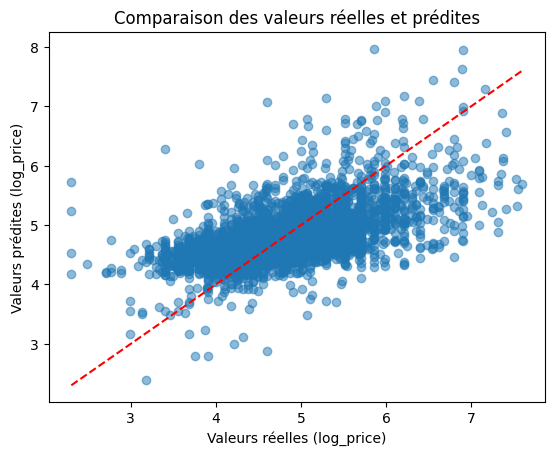

In [29]:
import matplotlib.pyplot as plt

# Scatter plot des valeurs réelles vs prédites
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeurs réelles (log_price)")
plt.ylabel("Valeurs prédites (log_price)")
plt.title("Comparaison des valeurs réelles et prédites")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Ligne idéale
plt.show()